# Práctica Bicimad

## Introducción

Esta práctica consiste en estudiar cómo ha afectado al uso del servicio Bicimad la medida impuesta el 30 de noviembre de 2018 en la Comunidad de Madrid de restrigir el paso de vehículos a un área del centro de Madrid para disminuir la contaminación. 

### Clases:

- user_day_code: id de cada viajero en un día concreto
- user_type: valor entre 0 y 3 que indica el tipo de usuario. 
    - 0: no se ha podido determinar el tipo de usuario
    - 1: abonado anual
    - 2: usuario ocasional
    - 3: trabajador de la empresa
- ageRange: rango de edad del usuario
    - 0: no se ha podido determinar la edad del usuario
    - 1: entre 0 y 16 años
    - 2: 17 y 18 años
    - 3: entre 19 y 26 años
    - 4: entre 27 y 40 años
    - 5: entre 41 y 65 años
    - 6: a partir de 66 años
- idunplug_station: id de la estación donde se inicia el viaje
- idplug_station: id de la estación donde se finaliza el viaje
- travel_time: duración en segundos del viaje
- zip_code: código postal donde reside el usuario


In [1]:
from pyspark import SparkContext
sc = SparkContext()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/28 20:45:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import json
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

In [3]:
!head -10 201801.json

In [4]:
rdd_base_ene18 = sc.textFile('201801.json')
rdd_base_ene19 = sc.textFile('201901.json')

rdd_base_feb18 = sc.textFile('201802.json')
rdd_base_feb19 = sc.textFile('201902.json')

rdd_base_mar18 = sc.textFile('201803.json')
rdd_base_mar19 = sc.textFile('201903.json')

rdd_base_abr18 = sc.textFile('201804.json')
rdd_base_abr19 = sc.textFile('201904.json')

rdd_base_may18 = sc.textFile('201805.json')
rdd_base_may19 = sc.textFile('201905.json')

rdd_base_jun18 = sc.textFile('201806.json')
rdd_base_jun19 = sc.textFile('201906.json')



In [5]:
def mapper(line):
    info = {}
    data = json.loads(line)
    info['user'] = data['user_day_code']
    info['user_type'] = int(data['user_type'])
    info['ageRange'] = int(data['ageRange'])
    info['start'] = data['idunplug_station']
    info['end'] = data['idplug_station']
    info['travel_time'] = int(data['travel_time'])
    info['zip_code'] = data['zip_code']
    return info

In [6]:
rdd = rdd_base_ene18.map(mapper)
rdd
rdd.take(3)

[{'user': 'b00665a845be18ed9f036c2d72def1ef2fa2c49365cb64644821b72d560b100f',
  'user_type': 1,
  'ageRange': 5,
  'start': 6,
  'end': 7,
  'travel_time': 284,
  'zip_code': '28010'},
 {'user': '65a82ac6353d9e8b25c17a49bb46d09426757b409463708b36e65bde4f2c786e',
  'user_type': 1,
  'ageRange': 0,
  'start': 24,
  'end': 117,
  'travel_time': 666,
  'zip_code': ''},
 {'user': '51b7da733980586e1f847b61cc4af9c0268fc2d09df63ee0e4c7ecc2866b8955',
  'user_type': 1,
  'ageRange': 0,
  'start': 24,
  'end': 117,
  'travel_time': 662,
  'zip_code': ''}]

Para realizar el estudio, nos centraremos en las estaciones de bicimad que se encuentran dentro de Madrid Central. En la imagen posterior, podemos observar el área de Madrid Central con sus estaciones de Bicimad.
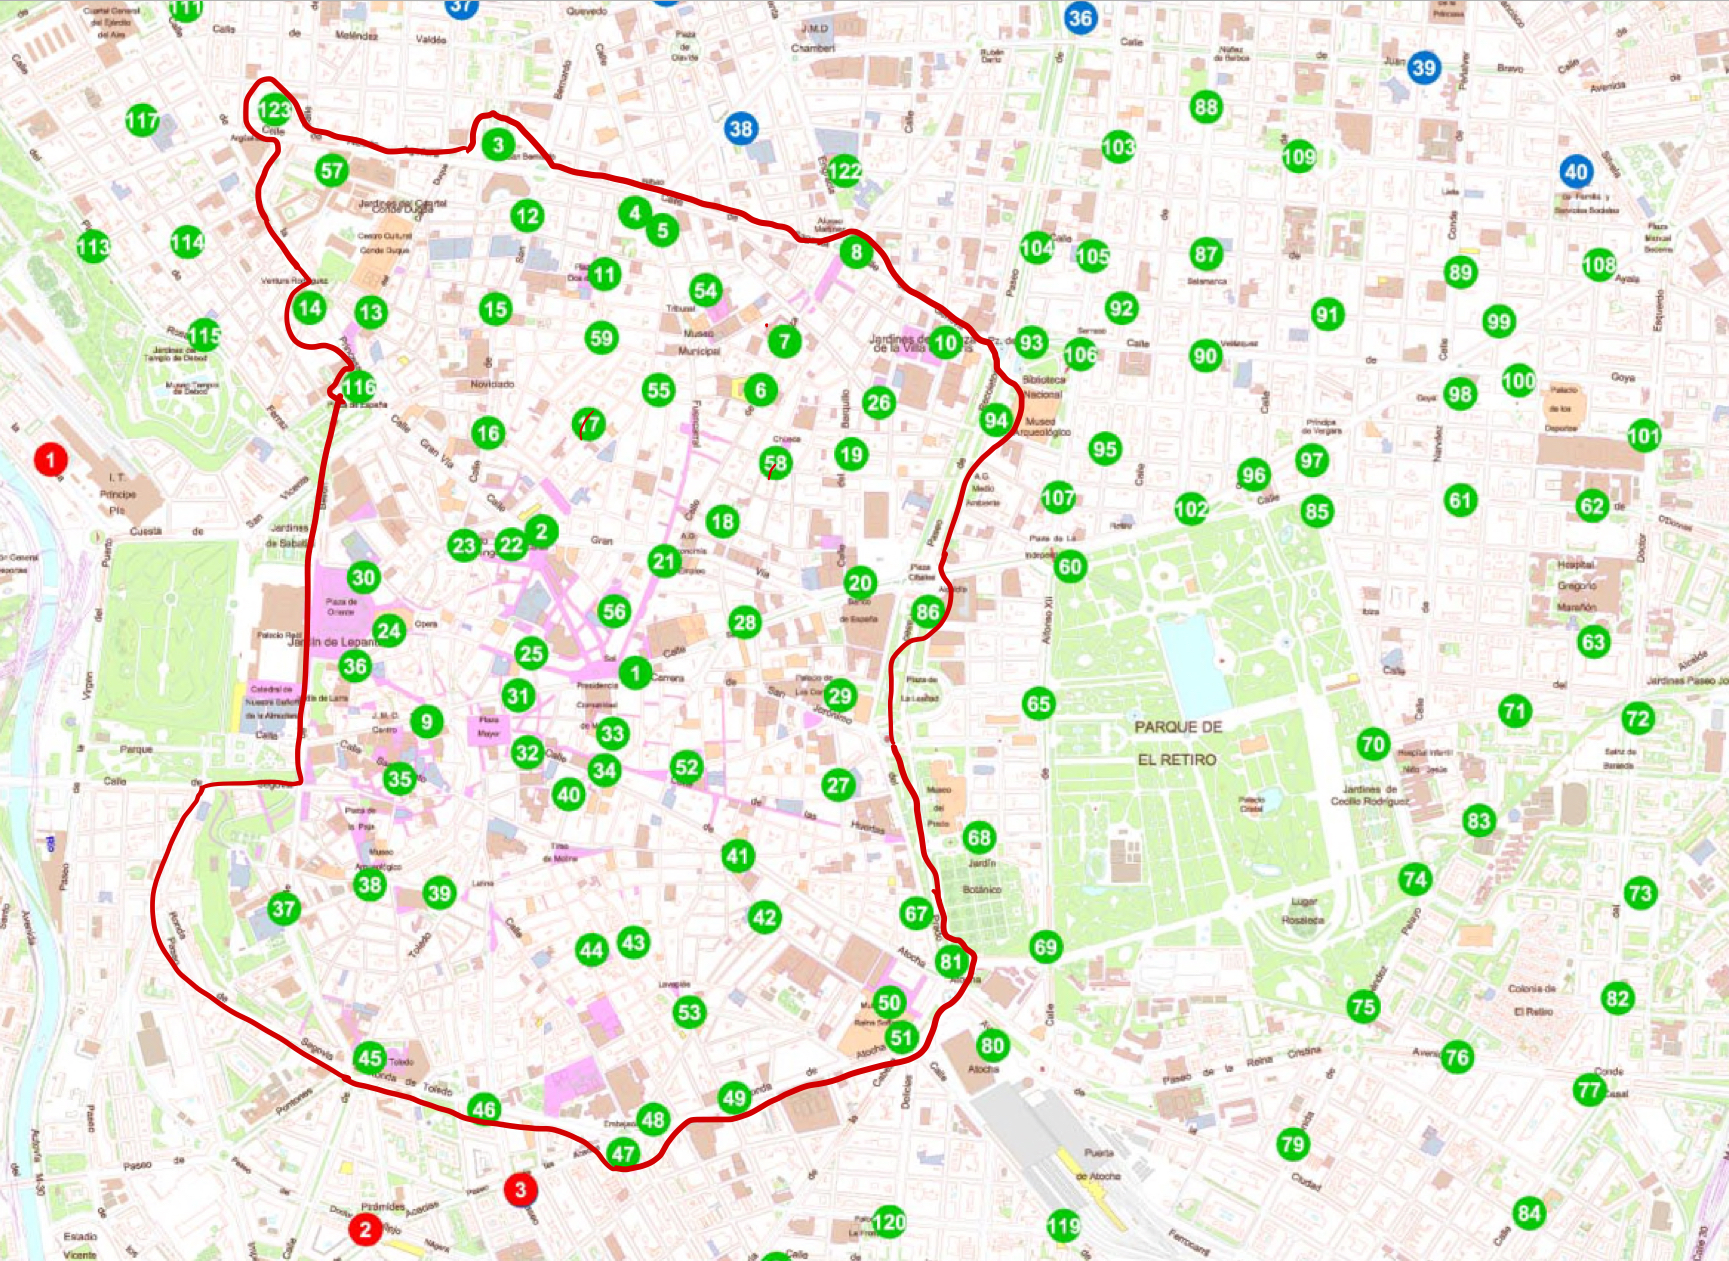 

In [7]:
estaciones_mad_central = [123, 57, 3, 12, 4, 5, 8, 14, 13, 15, 11, 54, 7, 10, 116, 59, 16, 17, 55, 6, 26, 94, 19, 58, 18, 21, 2, 22, 23, 30, 24, 36, 25, 56, 28, 20, 86, 29, 1, 31, 9, 35, 32, 33, 34, 40, 52, 27, 41, 37, 38, 39, 45, 44, 43, 42, 67, 81, 50, 51, 53, 46, 47, 48, 49]

23/05/28 20:45:14 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


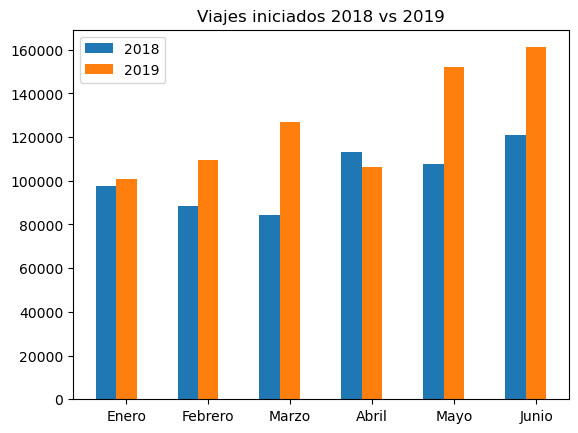

In [8]:
rdds_18 = [rdd_base_ene18, rdd_base_feb18, rdd_base_mar18, rdd_base_abr18, rdd_base_may18, rdd_base_jun18]
rdds_19 = [rdd_base_ene19, rdd_base_feb19, rdd_base_mar19, rdd_base_abr19, rdd_base_may19, rdd_base_jun19]

res_18 = []
res_19 = []
for i in rdds_18:
    n_viajes = i.map(mapper).filter(lambda x: x['start'] in estaciones_mad_central).count()
    res_18.append(n_viajes)

for i in rdds_19:
    n_viajes = i.map(mapper).filter(lambda x: x['start'] in estaciones_mad_central).count()
    res_19.append(n_viajes)   

    
data = pd.DataFrame({'año2018' : res_18,
                     'año2019': res_19},
                    index=('Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio'))

n = len(data.index)
x = np.arange(n)
width = 0.25
plt.bar(x - width, data.año2018, width=width, label='2018')
plt.bar(x, data.año2019, width=width, label='2019')
plt.xticks(x, data.index)
plt.legend(loc='best')
plt.title('Viajes iniciados 2018 vs 2019')
plt.show()


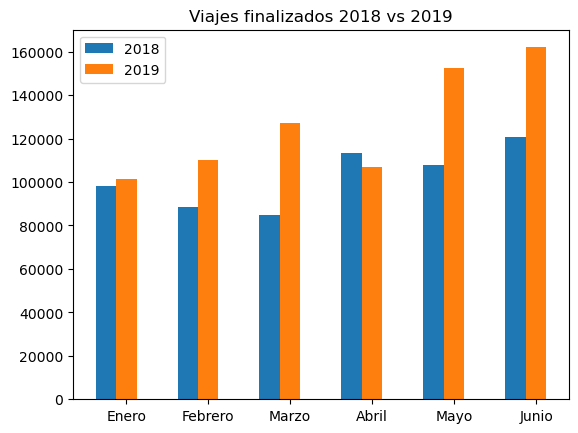

In [9]:
rdds_18 = [rdd_base_ene18, rdd_base_feb18, rdd_base_mar18, rdd_base_abr18, rdd_base_may18, rdd_base_jun18]
rdds_19 = [rdd_base_ene19, rdd_base_feb19, rdd_base_mar19, rdd_base_abr19, rdd_base_may19, rdd_base_jun19]

res_18 = []
res_19 = []
for i in rdds_18:
    n_viajes = i.map(mapper).filter(lambda x: x['end'] in estaciones_mad_central).count()
    res_18.append(n_viajes)

for i in rdds_19:
    n_viajes = i.map(mapper).filter(lambda x: x['end'] in estaciones_mad_central).count()
    res_19.append(n_viajes)   

    
data = pd.DataFrame({'año2018' : res_18,
                     'año2019': res_19},
                    index=('Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio'))

n = len(data.index)
x = np.arange(n)
width = 0.25
plt.bar(x - width, data.año2018, width=width, label='2018')
plt.bar(x, data.año2019, width=width, label='2019')
plt.xticks(x, data.index)
plt.legend(loc='best')
plt.title('Viajes finalizados 2018 vs 2019')
plt.show()

Las dos gráficas muestran el aumento de uso de Bicimad en Madrid Central. La diferencia entre ambos años va aumentando significativamente según avanzan los meses, a excepción de abril, que fue uno de los meses más húmedos de este siglo, https://www.aemet.es/es/noticias/2019/05/Abril_2019_muy_humedo, que puede ser una de las razones que explique esta anomalía.

In [10]:
niños_ene19 = rdd_base_ene19.map(mapper).filter(lambda x: x['ageRange'] in [1,2]).count()
jovenes_ene19 = rdd_base_ene19.map(mapper).filter(lambda x: x['ageRange'] in [3,4]).count()
mayores_ene19 = rdd_base_ene19.map(mapper).filter(lambda x: x['ageRange'] in [5,6]).count()

niños_feb19 = rdd_base_feb19.map(mapper).filter(lambda x: x['ageRange'] in [1,2]).count()
jovenes_feb19 = rdd_base_feb19.map(mapper).filter(lambda x: x['ageRange'] in [3,4]).count()
mayores_feb19 = rdd_base_feb19.map(mapper).filter(lambda x: x['ageRange'] in [5,6]).count()

niños_mar19 = rdd_base_mar19.map(mapper).filter(lambda x: x['ageRange'] in [1,2]).count()
jovenes_mar19 = rdd_base_mar19.map(mapper).filter(lambda x: x['ageRange'] in [3,4]).count()
mayores_mar19 = rdd_base_mar19.map(mapper).filter(lambda x: x['ageRange'] in [5,6]).count()

niños_abr19 = rdd_base_abr19.map(mapper).filter(lambda x: x['ageRange'] in [1,2]).count()
jovenes_abr19 = rdd_base_abr19.map(mapper).filter(lambda x: x['ageRange'] in [3,4]).count()
mayores_abr19 = rdd_base_abr19.map(mapper).filter(lambda x: x['ageRange'] in [5,6]).count()

niños_may19 = rdd_base_may19.map(mapper).filter(lambda x: x['ageRange'] in [1,2]).count()
jovenes_may19 = rdd_base_may19.map(mapper).filter(lambda x: x['ageRange'] in [3,4]).count()
mayores_may19 = rdd_base_may19.map(mapper).filter(lambda x: x['ageRange'] in [5,6]).count()


niños_jun19 = rdd_base_jun19.map(mapper).filter(lambda x: x['ageRange'] in [1,2]).count()
jovenes_jun19 = rdd_base_jun19.map(mapper).filter(lambda x: x['ageRange'] in [3,4]).count()
mayores_jun19 = rdd_base_jun19.map(mapper).filter(lambda x: x['ageRange'] in [5,6]).count()

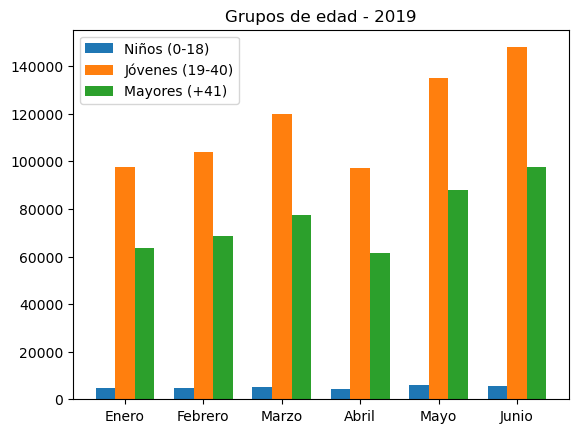

In [11]:
data = pd.DataFrame({'Niños' : [niños_ene19, niños_feb19, niños_mar19, niños_abr19, niños_may19, niños_jun19],
                     'Jovenes': [jovenes_ene19, jovenes_feb19, jovenes_mar19, jovenes_abr19, jovenes_may19, jovenes_jun19],
                     'Mayores': [mayores_ene19, mayores_feb19, mayores_mar19, mayores_abr19, mayores_may19, mayores_jun19]},
                    index=('Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio'))

n = len(data.index)
x = np.arange(n)
width = 0.25
plt.bar(x - width, data.Niños, width=width, label='Niños (0-18)')
plt.bar(x, data.Jovenes, width=width, label='Jóvenes (19-40)')
plt.bar(x + width, data.Mayores, width=width, label='Mayores (+41)')
plt.xticks(x, data.index)
plt.legend(loc='best')
plt.title('Grupos de edad - 2019')
plt.show()


La gráfica muestra el número de viajes al mes de los distintas edades en el año 2019. El grupo más predominante es el comprendido entre 19 y 40 años que como es lógico es más propenso a utilizar este tipo de servicios, y el menos predominante es el de menores de edad, que por razones obvias necesitan ir acompañados y esto hace que lo utilizan con menor frecuencia.

In [12]:
def count_estaciones(values):
    values = values.map(lambda x: (x['start'],1)).groupByKey().mapValues(len).collect()
    values = sorted([(x[1],x[0]) for x in values])
    values = [(x[1],x[0]) for x in values]
    return values

estaciones = count_estaciones(rdd_base_ene19.map(mapper).filter(lambda x: x['start'] in estaciones_mad_central))
estacion_fav = estaciones[-1]
estacion_peor = estaciones[0]


estacion_fav, estacion_peor

((43, 3583), (28, 285))

La estación más utilizada en Madrid Central en enero 2019 se encuentra en: Calle Alcalá, 27
La estación menos utilizada en Madrid Central en enero 2019 se encuentra en: Calle Lavapiés, 34

In [13]:
rdd_mas_de_un_viaje = rdd_base_ene19.map(mapper).filter(lambda x: x['start'] in estaciones_mad_central).map(lambda x: (x['user'],[x['start'], x['end']])).groupByKey().mapValues(tuple)\
    .filter(lambda x: len(x[1])>1)

rdd_mas_de_un_viaje.take(10)

[('58ba8b1ada60486c0ce079ade7fd291da026d029db3526885b1c58e2456b53a2',
  ([67, 47], [47, 67], [67, 47])),
 ('d7c9955a35d53c4d8164d637e1b8c3acdda7301cc0efd8528dbb2a21b6f30f93',
  ([67, 65], [67, 84])),
 ('49afce74b0e124e40ba354159b4c4f08a6dd23ea7d680a3faa676d6eca01194c',
  ([56, 51], [51, 151])),
 ('6df2739f0a18bdcb29724d40270c745ebdc982abfb55835ea6fe6c71713e47a5',
  ([40, 27], [27, 91])),
 ('b9a839c98cbd2d547acf5e13364e490079c04c409796f8453f03038e60b3ef7c',
  ([57, 30], [57, 40])),
 ('b7307ebb0662c8c766d9315fc9892f483d0b98920899048f03d5dd6af5a601e6',
  ([44, 16], [16, 16], [16, 19])),
 ('595b5f1a83c99ad0d641df135c90c86f38df0e80b7fd818c8fdffa53db50cbfc',
  ([5, 56], [56, 6])),
 ('c01e051eb939ca4fed67a33264987082325f123b1de9f725602e956602164af1',
  ([116, 169],
   [116, 169],
   [116, 169],
   [116, 169],
   [116, 169],
   [116, 169],
   [116, 169],
   [6, 6])),
 ('29ad5741c5ac8c73838bbe81d63842fe41274ff122dafe66dad6f1d592422c24',
  ([31, 38], [3, 31])),
 ('623cac7ccd6e01c8b52c0991f7e2b52

En este RDD, recogemos los usuarios que han realizado más de un viaje en un día.

In [14]:
def es_ciclo(data):
    result = False
    for i in range(len(data[1])):
        j = i + 1
        while j<len(data[1]) and not result:
            result = data[1][i][0]==data[1][j][1]
            j+=1
    return result
        

Para contar que un usuario ha realizado un ciclo, hemos considerado que el usuario termina un viaje en la misma estación donde había empezado uno anterior.

In [15]:
cycles = rdd_mas_de_un_viaje.filter(lambda x: es_ciclo(x))
cycles.count()

porcentaje_cycles = cycles.count()/rdd_mas_de_un_viaje.count()

porcentaje_cycles

0.3412771722396699

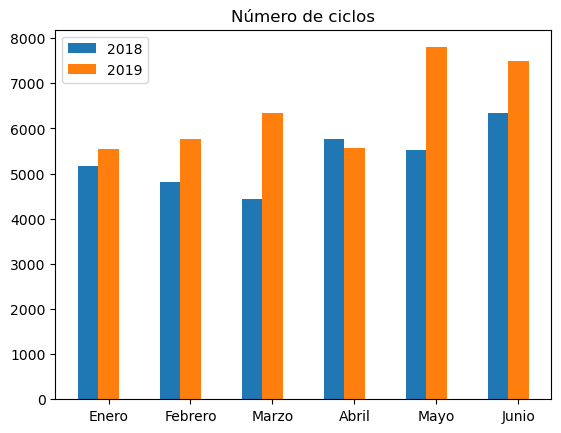

In [16]:
rdds_18 = [rdd_base_ene18, rdd_base_feb18, rdd_base_mar18, rdd_base_abr18, rdd_base_may18, rdd_base_jun18]
rdds_19 = [rdd_base_ene19, rdd_base_feb19, rdd_base_mar19, rdd_base_abr19, rdd_base_may19, rdd_base_jun19]

cic_18 = []
cic_19 = []

for i in rdds_18:
    data_reps = i.map(mapper).filter(lambda x: x['start'] in estaciones_mad_central).map(lambda x: (x['user'],[x['start'], x['end']])).groupByKey().mapValues(tuple)\
    .filter(lambda x: len(x[1])>1)
    ciclos = data_reps.filter(lambda x: es_ciclo(x)).count()
    cic_18.append(ciclos)

for i in rdds_19:
    data_reps = i.map(mapper).filter(lambda x: x['start'] in estaciones_mad_central).map(lambda x: (x['user'],[x['start'], x['end']])).groupByKey().mapValues(tuple)\
    .filter(lambda x: len(x[1])>1)
    ciclos = data_reps.filter(lambda x: es_ciclo(x)).count()
    cic_19.append(ciclos)
    
data = pd.DataFrame({'año2018' : cic_18,
                     'año2019': cic_19},
                    index=('Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio'))

n = len(data.index)
x = np.arange(n)
width = 0.25
plt.bar(x - width, data.año2018, width=width, label='2018')
plt.bar(x, data.año2019, width=width, label='2019')
plt.xticks(x, data.index)
plt.legend(loc='best')
plt.title('Número de ciclos')
plt.show()    

En esta gráfica podemos observar que la diferencia entre 2018 y 2019 en el número de ciclos en Madrid Central aumenta considerablemente según avanzan los meses, acorde con el aumento del uso de Bicimad observado anteriormente.

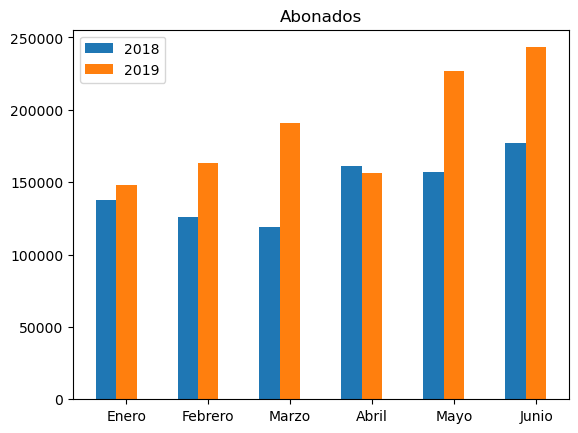

In [17]:
rdds_18 = [rdd_base_ene18, rdd_base_feb18, rdd_base_mar18, rdd_base_abr18, rdd_base_may18, rdd_base_jun18]
rdds_19 = [rdd_base_ene19, rdd_base_feb19, rdd_base_mar19, rdd_base_abr19, rdd_base_may19, rdd_base_jun19]

res_18 = []
res_19 = []

for i in rdds_18:
    abonados = i.map(mapper).filter(lambda x: x['start'] in estaciones_mad_central or x['end'] in estaciones_mad_central).filter(lambda x: x['user_type']==1).count()
    res_18.append(abonados)

for i in rdds_19:
    abonados = i.map(mapper).filter(lambda x: x['start'] in estaciones_mad_central or x['end'] in estaciones_mad_central).filter(lambda x: x['user_type']==1).count()
    res_19.append(abonados)

data = pd.DataFrame({'año2018' : res_18,
                     'año2019': res_19},
                    index=('Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio'))

n = len(data.index)
x = np.arange(n)
width = 0.25
plt.bar(x - width, data.año2018, width=width, label='2018')
plt.bar(x, data.año2019, width=width, label='2019')
plt.xticks(x, data.index)
plt.legend(loc='best')
plt.title('Abonados')
plt.show()

En esta gráfica podemos observar que la diferencia entre 2018 y 2019 en el número de abonados anuales que inician o finalizan su viaje en Madrid Central aumenta considerablemente según avanzan los meses, acorde con el aumento del uso de Bicimad observado anteriormente.